# About notebook

Dataset
*	Groningen Meaning Bank (version 2.2.0)
*	Task: named entity recognition
*	Target – named entity tags (BIO + entity type)
*	Input data: 
  * Use “en.met” files to extract the subcorpus
  corpus = 'Voice of America' (for honogeneity of the input data set)
  * Use "en.tags" files for the main input data:
      *	raw tokens + may use the lemmas and the POS-tags 
  (i.e. take the “golden” POS-tagging);
      *	which means:
        *	first three columns for input: ['word', 'pos', 'lemma']
        *	the fourth column for target variable (‘ne_tags’)
        (BIO annotation + the named-entity type in one tag)  

# Tasks

1.	The most trivial model = supervised HMM:
  *	Take hmmlearn (former sklearn), modify MultinomialHMM (I.e. inherit a new class from _BaseHMM making it a modified copy of the latter) to allow for supervised HMM training. The states of the HMM model = the NE tags.
  *	NOTE: may use NaiveBayes to learn emission probabilities in a supervized manner.
  *	Or implement from scratch (with Viterbi for prediction).
  *	NOTE: use tuples of features for X (not just the word, but additional info).
  *	NOTE: use smoothing for state transitions.
2.	CRF
  *	Modify the input features;
  *	Use CRFSuite.
3.	Bi-LSTM:
  *	Use keras or tensorflow;
  *	https://github.com/hse-aml/natural-language-processing/blob/master/week2/week2-NER.ipynb
  *	A plus for incorporating CNN-layers;

# Metrics

* normalized confusion matrices, precision, recall, F-score 
(macro- and micro-) 
* (token level, entity level, partial matching (i.e. boundary-detection problem), binary).  
NOTE: taking into account vocabulary transfer is a plus.

# Evaluation Criteria

Scoring (14.5 max):  
*	Dataset overview – 0.5
  *	text lengths, vocabulary size, frequencies of patterns (<UNK-type-i>) 
  *	stats over the target tags
*	Feature engineering – 2 (1+1)
  *	grammatical words = closed set (~ stop words)
  *	Stemming + POS
  *	Word shape
  *	Ad hoc features ( +1)  
*	Word patterns -> encode types of unknown words +0.5
*	Smoothing in HMM – 0.5 
  *	In HMM: for state transitions.
*	Incorporating tupled features in HMM (on top of tokens) – 1
*	The correct HMM implementation – 1
*	More fine-grained feature engineering for the Neural Network + 0.5
  *	Differentiate between POS-relevancy for the word and the context, etc.
  *	Sentence-level features (may use “golden” sentence-splitting)
*	Evaluation (on all levels) – 1
*	Conclusion on HMM deficiency (as a model) – 1
*	CRF: 1 point for use and evaluation, + 0.5 points for comparison and conclusions;
*	NN:
  *	Main network: 4
  *	CNN layers: +2  

Libraries: hmmlearn, crfsuite, tensorflow, keras

# Libs import

In [1]:
%autosave 180
%load_ext autoreload
%autoreload 2

from nltk import word_tokenize, pos_tag, ne_chunk
import os
import pandas as pd
import codecs
from collections import Counter
import re
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate, ShuffleSplit
from sklearn_crfsuite import CRF
from sklearn.metrics import recall_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

%matplotlib inline

Autosaving every 180 seconds


# Configs

In [2]:
data_path = 'D:\Data\gmb-2.2.0\data'
print('data found:', os.listdir(data_path))

data found: ['p00', 'p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p07', 'p08', 'p09', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69', 'p70', 'p71', 'p72', 'p73', 'p74', 'p75', 'p76', 'p77', 'p78', 'p79', 'p80', 'p81', 'p82', 'p83', 'p84', 'p85', 'p86', 'p87', 'p88', 'p89', 'p90', 'p91', 'p92', 'p93', 'p94', 'p95', 'p96', 'p97', 'p98', 'p99']


In [3]:
subcorpus = 'Voice of America'

# Data extraction

Parsing data from "Voice of America" subcorpus. According to the instructions we take first four columns and additional column to separate data on texts, sentences or words.

In [40]:
%%time

voa_data = pd.DataFrame(columns=['word', 'pos', 'lemma', 'ne_tags', 'text_id'])

os.chdir(data_path)
part_paths = os.listdir()

for part_path in tqdm(part_paths, total=len(part_paths)):
    os.chdir(part_path)
    document_paths = os.listdir()
    for document_path in document_paths:
        os.chdir(document_path)
        f = codecs.open("en.met", 'r', "utf_8_sig")
        file_met = f.read()
        if ('subcorpus: {}'.format(subcorpus) in file_met):
            tags_df = pd.read_csv('en.tags',
                                  sep='\t',
                                  header=None,
                                  names=['word', 'pos', 'lemma', 'ne_tags'],
                                  usecols=[0, 1, 2, 3],
                                  error_bad_lines=False)
            tags_df['text_id'] = str(part_path) + '_' + str(document_path)
            voa_data = voa_data.append(tags_df, ignore_index=True)
        f.close()
        os.chdir('..')
    os.chdir('..')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [08:55<00:00,  5.36s/it]

Wall time: 8min 55s


In [181]:
def show_memory_usage(df):
    print("memory usage: ", df.memory_usage().sum()/1024/1024, " MB")

In [15]:
show_memory_usage(voa_data)

memory usage:  46.969688415527344  MB


In [13]:
voa_data.head()

,word,pos,lemma,ne_tags,text_id
0,Thousands,NNS,thousand,O,p00_d0018
1,of,IN,of,O,p00_d0018
2,demonstrators,NNS,demonstrator,O,p00_d0018
3,have,VBP,have,O,p00_d0018
4,marched,VBN,march,O,p00_d0018


In [16]:
voa_data.shape

(1231279, 5)

Number of tokens coincided with the declared in README file

In [18]:
voa_data.to_csv('D:\Data\gmb-2.2.0\{}.csv'.format(subcorpus), index=False)

# EDA

In [4]:
voa_data = pd.read_csv('D:\Data\gmb-2.2.0\{}.csv'.format(subcorpus))
voa_data.head()

,word,pos,lemma,ne_tags,text_id
0,Thousands,NNS,thousand,O,p00_d0018
1,of,IN,of,O,p00_d0018
2,demonstrators,NNS,demonstrator,O,p00_d0018
3,have,VBP,have,O,p00_d0018
4,marched,VBN,march,O,p00_d0018


In [5]:
def average_text_length(text_id):
    doc_lengths = list(dict(Counter(text_id)).values())
    sum = 0
    for length in doc_lengths:
        sum += length
    return sum/len(doc_lengths)

print("average text length: ", average_text_length(voa_data['text_id']))

average text length:  134.31646121959201


In [6]:
voa_data.describe()

,word,pos,lemma,ne_tags,text_id
count,1231279,1231279,1231279,1231279,1231279
unique,35154,48,27209,25,9167
top,the,NN,the,O,p00_d0090
freq,61398,168817,74941,1032479,388


In [41]:
voa_data['ne_tags'].value_counts()

O          1032479
geo-nam      55480
org-nam      44646
per-nam      22931
gpe-nam      19685
tim-dow      11398
tim-dat      10929
per-tit       9672
per-fam       8098
[]            4064
tim-moy       3811
tim-yoc       3009
per-giv       2376
tim-clo        810
art-nam        789
eve-nam        514
nat-nam        280
tim-nam        132
eve-ord         63
per-ini         55
per-ord         35
org-leg         13
tim-dom          8
art-add          1
per-mid          1
Name: ne_tags, dtype: int64

# Make BIO

In [7]:
voa_data.head(2)

,word,pos,lemma,ne_tags,text_id
0,Thousands,NNS,thousand,O,p00_d0018
1,of,IN,of,O,p00_d0018


In [30]:
def use_prev_value_decorator(func):
    prev_tag = "O"

    def wrapper(curr_tag, **kwargs):
        nonlocal prev_tag
        bio_tag = func(curr_tag, prev_tag)
        prev_tag = curr_tag
        return bio_tag

    return wrapper


@use_prev_value_decorator
# Tag tokens with standard NLP BIO tags
def bio_tagger(curr_tag, prev_tag):
    if curr_tag == "O":  #O
        return curr_tag
    elif curr_tag != "O" and prev_tag == "O":  # Begin NE
        return "B-" + curr_tag
    elif prev_tag != "O" and prev_tag == curr_tag:  # Inside NE
        return "I-" + curr_tag
    elif prev_tag != "O" and prev_tag != curr_tag:  # Adjacent NE
        return "B-" + curr_tag

In [33]:
voa_data['bio_tag'] = voa_data['ne_tags'].apply(bio_tagger, axis=1)

In [36]:
voa_data['bio_tag'].value_counts().head()

O            1032479
B-geo-nam      46622
B-org-nam      24134
I-org-nam      20512
B-gpe-nam      19469
Name: bio_tag, dtype: int64

# Preprocessing

Classificators work better if avoid redundant granularity. Also such detailed fragmentation has no value for the task of only finding named entities. Thus, we can combine subcategories and leave only first part of tag.

In [47]:
voa_data['ne_tags'] = voa_data['ne_tags'].apply(lambda x: x.split('-')[0])

In [48]:
voa_data['ne_tags'].value_counts()

O      1032479
geo      55480
org      44659
per      43168
tim      30097
gpe      19685
[]        4064
art        790
eve        577
nat        280
Name: ne_tags, dtype: int64

In [49]:
voa_data.head()

,word,pos,lemma,ne_tags,text_id
0,Thousands,NNS,thousand,O,p00_d0018
1,of,IN,of,O,p00_d0018
2,demonstrators,NNS,demonstrator,O,p00_d0018
3,have,VBP,have,O,p00_d0018
4,marched,VBN,march,O,p00_d0018


## For other models

In [5]:
voa_data.head(2)

,word,pos,lemma,ne_tags,text_id
0,Thousands,NNS,thousand,O,p00_d0018
1,of,IN,of,O,p00_d0018


In [6]:
def encode_labels(df, labels_list):
    for label in labels_list:
        le = LabelEncoder()
        df[label] = le.fit_transform(df[label])
    return df

In [7]:
voa_data = encode_labels(voa_data, ['ne_tags'])

In [8]:
target = voa_data['ne_tags']
voa_data.drop(['ne_tags', 'text_id'], axis=1, inplace=True)

In [9]:
voa_data = encode_labels(voa_data, ['word', 'pos', 'lemma'])

In [36]:
X_train, X_test, y_train, y_test = train_test_split(voa_data, target, test_size = 0.2, shuffle=True, stratify=target)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

## For CRF

In [24]:
def get_sentences(df):
    """func to get the sentences in this format:
    [(Token_1, Part_of_Speech_1, Tag_1), ..., (Token_n, Part_of_Speech_n, Tag_n)]"""
    
    agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["word"].values.tolist(),
                                                       s["pos"].values.tolist(),
                                                       s["ne_tags"].values.tolist())]
    grouped = df.groupby("text_id").apply(agg_func)
    sentences = [s for s in grouped]
    
    return sentences

In [25]:
%%time

word_pos_tag_sentences = get_sentences(voa_data)
display(word_pos_tag_sentences[:2])

[[('Thousands', 'NNS', 'O'),
  ('of', 'IN', 'O'),
  ('demonstrators', 'NNS', 'O'),
  ('have', 'VBP', 'O'),
  ('marched', 'VBN', 'O'),
  ('through', 'IN', 'O'),
  ('London', 'NNP', 'geo-nam'),
  ('to', 'TO', 'O'),
  ('protest', 'VB', 'O'),
  ('the', 'DT', 'O'),
  ('war', 'NN', 'O'),
  ('in', 'IN', 'O'),
  ('Iraq', 'NNP', 'geo-nam'),
  ('and', 'CC', 'O'),
  ('demand', 'VB', 'O'),
  ('the', 'DT', 'O'),
  ('withdrawal', 'NN', 'O'),
  ('of', 'IN', 'O'),
  ('British', 'JJ', 'gpe-nam'),
  ('troops', 'NNS', 'O'),
  ('from', 'IN', 'O'),
  ('that', 'DT', 'O'),
  ('country', 'NN', 'O'),
  ('.', '.', 'O'),
  ('Families', 'NNS', 'O'),
  ('of', 'IN', 'O'),
  ('soldiers', 'NNS', 'O'),
  ('killed', 'VBN', 'O'),
  ('in', 'IN', 'O'),
  ('the', 'DT', 'O'),
  ('conflict', 'NN', 'O'),
  ('joined', 'VBD', 'O'),
  ('the', 'DT', 'O'),
  ('protesters', 'NNS', 'O'),
  ('who', 'WP', 'O'),
  ('carried', 'VBD', 'O'),
  ('banners', 'NNS', 'O'),
  ('with', 'IN', 'O'),
  ('such', 'JJ', 'O'),
  ('slogans', 'NNS', 'O')

Wall time: 1.55 s


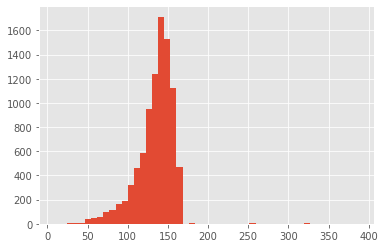

In [26]:
#Lets visualize how the sentences are distributed by their length
plt.style.use("ggplot")
plt.hist([len(s) for s in word_pos_tag_sentences], bins=50)
plt.show()

In [7]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:], #replace with BPE
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def get_sent_labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

### Split

In [8]:
len(word_pos_tag_sentences)

9167

In [9]:
X = [sent2features(s) for s in word_pos_tag_sentences]
y = [get_sent_labels(s) for s in word_pos_tag_sentences]

In [28]:
X[:2]

[[{'bias': 1.0,
   'word.lower()': 'thousands',
   'word[-3:]': 'nds',
   'word[-2:]': 'ds',
   'word.isupper()': False,
   'word.istitle()': True,
   'word.isdigit()': False,
   'postag': 'NNS',
   'postag[:2]': 'NN',
   'BOS': True,
   '+1:word.lower()': 'of',
   '+1:word.istitle()': False,
   '+1:word.isupper()': False,
   '+1:postag': 'IN',
   '+1:postag[:2]': 'IN'},
  {'bias': 1.0,
   'word.lower()': 'of',
   'word[-3:]': 'of',
   'word[-2:]': 'of',
   'word.isupper()': False,
   'word.istitle()': False,
   'word.isdigit()': False,
   'postag': 'IN',
   'postag[:2]': 'IN',
   '-1:word.lower()': 'thousands',
   '-1:word.istitle()': True,
   '-1:word.isupper()': False,
   '-1:postag': 'NNS',
   '-1:postag[:2]': 'NN',
   '+1:word.lower()': 'demonstrators',
   '+1:word.istitle()': False,
   '+1:word.isupper()': False,
   '+1:postag': 'NNS',
   '+1:postag[:2]': 'NN'},
  {'bias': 1.0,
   'word.lower()': 'demonstrators',
   'word[-3:]': 'ors',
   'word[-2:]': 'rs',
   'word.isupper()': F

In [17]:
ne_tags = voa_data['ne_tags'].unique()
ne_tags

array(['O', 'geo-nam', 'gpe-nam', '[]', 'per-fam', 'org-nam', 'tim-dow',
       'art-nam', 'per-tit', 'per-giv', 'per-nam', 'tim-yoc', 'tim-moy',
       'tim-dom', 'tim-dat', 'tim-nam', 'nat-nam', 'eve-ord', 'eve-nam',
       'tim-clo', 'per-ord', 'per-ini', 'org-leg', 'per-mid', 'art-add'],
      dtype=object)

In [27]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y[:2])

le.classes_

TypeError: argument must be a string or number

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True)

# Training model

In [16]:
from sklearn.metrics import make_scorer, roc_auc_score
scoring = make_scorer(roc_auc_score, needs_proba=True, average='weighted', multi_class='ovr')
cv = ShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

## Naive Bayes

In [13]:
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB

### Bernoulli

In [14]:
X_train.head(2)

,word,pos,lemma
365118,23,2,16
430144,27891,10,18001


In [35]:
bernoulliCLF = RandomForestClassifier()

bernoulliCLF.fit(X_train, y_train)

y_pred = bernoulliCLF.predict(X_test)
y_pred

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    206238
           1       1.00      1.00      1.00       804
           3       0.37      0.15      0.22       168
           4       0.38      0.14      0.20        95
           5       0.41      0.82      0.55        11
           6       0.81      0.87      0.84     11266
           7       0.99      0.94      0.96      3966
           8       0.63      0.58      0.61        57
           9       1.00      0.33      0.50         3
          10       0.76      0.64      0.70      8913
          11       0.88      0.90      0.89      1648
          12       0.86      0.79      0.82       514
          13       0.80      0.89      0.84         9
          14       0.00      0.00      0.00         1
          15       0.75      0.78      0.76      4612
          16       0.00      0.00      0.00        11
          17       0.92      0.96      0.94      1962
          18       0.78    

C:\Users\Oleg\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
scores = cross_validate(BernoulliNB(), X_train, y_train, cv=cv, n_jobs=-1, 
                        scoring=scoring, verbose=100)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
Pickling array (shape=(3,), dtype=object).
Memmapping (shape=(985023,), dtype=int64) to new file C:\Users\Oleg\AppData\Local\Temp\joblib_memmapping_folder_23576_9312356208\23576-1560074912544-306ce5811dbb4b66b62623150468230d.pkl
Memmapping (shape=(3, 985023), dtype=int32) to new file C:\Users\Oleg\AppData\Local\Temp\joblib_memmapping_folder_23576_9312356208\23576-1560074912544-4f49efd3a67244c6b96efdb9249fc20b.pkl
Pickling array (shape=(3,), dtype=object).
Memmapping (shape=(985023,), dtype=int64) to new file C:\Users\Oleg\AppData\Local\Temp\joblib_memmapping_folder_23576_9312356208\23576-1560074912544-bcb30020675d4c18adb8d7b97e180c4a.pkl
Memmapping (shape=(985023,), dtype=int32) to new file C:\Users\Oleg\AppData\Local\Temp\joblib_memmapping_folder_23576_9312356208\23576-1560074912544-376e0bf02d7445838cd1faf84f72d354.pkl
Memmapping (shape=(985023,), dtype=int64) to new file C:\Users\Oleg\AppData\Local\Temp\jobli

ValueError: Number of classes in y_true not equal to the number of columns in 'y_score'

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
RandomForestClassifier().fit(voa_data[:100], target[:100])

D:\Programs\IDE_and_for_programming\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ValueError: could not convert string to float: 'in'

### Gaussian

In [32]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

## CRF

In [12]:
scoring = ['roc_auc']
cv = ShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

In [29]:
crf=CRF(algorithm='lbfgs',
         c1=0.1,
         c2=0.1,
         max_iterations=100,
         all_possible_transitions=False)

In [ ]:
crf.fit()

In [14]:
# scores = cross_validate(crf, X_train, y_train, cv=cv, n_jobs=-1, 
#                          scoring=scoring, verbose=100)
scores = cross_validate(crf, X_train[:100], y_train[:100], cv=cv, n_jobs=-1, 
                         scoring=scoring, verbose=100)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
Pickling array (shape=(70,), dtype=int32).
Pickling array (shape=(30,), dtype=int32).
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.2s


ValueError: You appear to be using a legacy multi-label data representation. Sequence of sequences are no longer supported; use a binary array or sparse matrix instead - the MultiLabelBinarizer transformer can convert to this format.

In [83]:
scores

array([0.97032539, 0.97388456, 0.97253039, 0.97323582, 0.97233593])